In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
!ls 
directory = "./drive/MyDrive/PC-BACKUP/UFRJ/IC-LAND/camera_Data/input/"
# Data for plotting

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


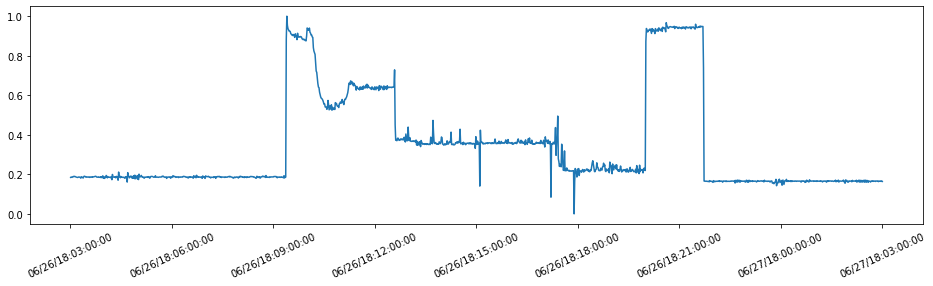

In [ ]:
df = pd.read_csv(directory+'/2018-6-26/net.if.out(eth0.2).csv')
df1 = pd.read_csv(directory+'2018-6-25/net.if.out(eth0.2).csv')
df2 = pd.read_csv(directory+'2018-6-22/net.if.out(eth0.2).csv')
def preprocess(df):
  df = df.loc[df.mac == 'B0-4E-26-F9-C6-54']
  df = df.sort_values('timestamp', ascending=True)
  convert = lambda x: datetime.fromtimestamp(x)
  df['timestamp'] = df['timestamp'].apply(convert)
  xmin = np.min(df['value'])
  xmax = np.max(df['value'])
  convert2 = lambda x: (x - xmin)/(xmax - xmin)
  df['value'] = df['value'].apply(convert2)
  return df
df = preprocess(df)
def plotCP(df,result=None):
  fig, ax = plt.subplots()
  fig.set_figheight(4)
  fig.set_figwidth(16)
  xfmt = md.DateFormatter('%D:%H:%M:%S')
  ax.xaxis.set_major_formatter(xfmt)
  ax.plot(df['timestamp'],df['value'])
  if result is not plotCP.__defaults__[0]:
    x = [df['timestamp'].iloc[i] for i in result]
    if len(x)%2 == 1:
      x.pop()
    for i in range(0,len(x),2):
      ax.axvspan(x[i],x[i+1], alpha=0.5, color='red')
    ax.vlines(x,0,1,linestyles='dashed')
    ax.set_ylim(0,1)
  plt.xticks(rotation=25)
plotCP(df)

In [ ]:
df.shape[0]

1432

In [ ]:
def cusum(Y, threshold=1.0, mean=0.0,sigma=0.0,delta=0.0):
  s_pos = list()
  s_neg = list()
  alarm_indexes = list()
  s_pos.append(0.0)
  s_neg.append(0.0)
  #Y = np.atleast_1d(Y).astype('float')
  for i in range(1,len(Y)-1):
    #print(type(0.0),type(s_pos[-1]),type(Y[i]),type(mean + delta*sigma) )
    #break
    maximo = s_pos[-1]+Y[i]-(mean + delta*sigma)
    if maximo < 0:
      maximo = 0
    s_pos.append(maximo)
    maximo = s_neg[-1]-Y[i]+(mean - delta*sigma)
    if maximo < 0:
      maximo = 0
    s_neg.append(maximo)
    if s_pos[-1] > threshold or s_neg[-1] > threshold:
      alarm_indexes.append(i)
      s_pos.append(0)
      s_neg.append(0)
  return alarm_indexes
    


In [ ]:
df['value'].values

array([0.18453444, 0.18631965, 0.18437784, ..., 0.16414545, 0.16636913,
       0.16414545])

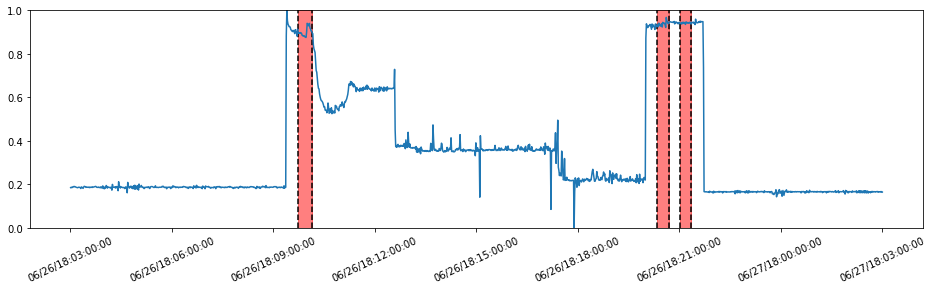

In [ ]:
#np.percentile(df['value'],75)
result = cusum(Y=df['value'].to_numpy(),threshold=5,mean=np.mean(df['value']),sigma=np.std(df['value']),delta=1.4)
plotCP(df,result)

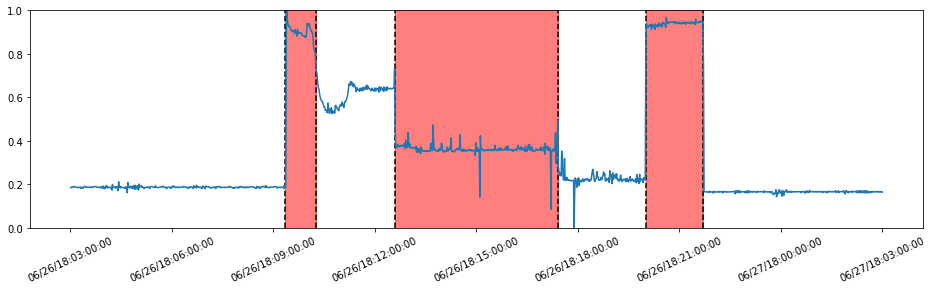

In [ ]:
!pip install ruptures
import ruptures as rpt
# detection
algo = rpt.Pelt(model="l1").fit(df['value'].to_numpy())
result = algo.predict(pen=10)
result -= np.ones_like(result)
plotCP(df,result)

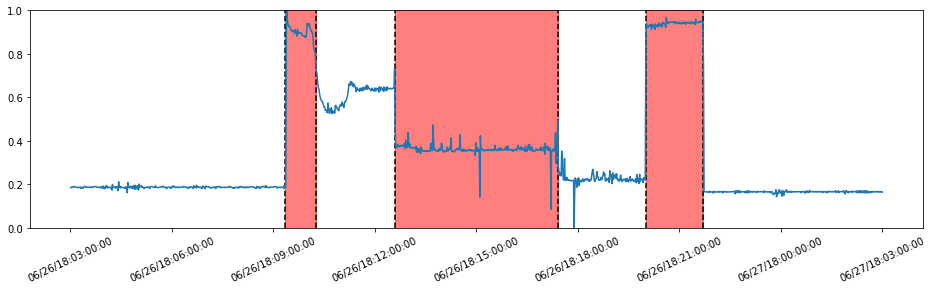

In [ ]:
algo = rpt.Binseg(model='rbf').fit(df['value'].to_numpy())
result = algo.predict(pen=10)
result -= np.ones_like(result)
plotCP(df,result)

In [ ]:
len(df)

1432

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from keras.models import Sequential

In [ ]:
# define model
def get_model(Input_shape,rpt_vec=0):
  model = Sequential()
  model.add(LSTM(100, activation='relu', input_shape=Input_shape,return_sequences=False))
  model.add(RepeatVector(rpt_vec))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  #model.add(keras.layers.Flatten())
  model.compile(optimizer='adam', loss="mean_squared_error",
          metrics=["mean_absolute_error"])
  return model
input_shape = (30,1)
model = get_model(input_shape,30)

In [ ]:
mae = []
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        #print("For batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))
        mae.append(logs["mean_absolute_error"])

    """def on_test_batch_end(self, batch, logs=None):
        print("For batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))
    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and mean absolute error is {:7.2f}.".format(
                epoch, logs["loss"], logs["mean_absolute_error"]
            )
        )"""

In [ ]:
df = pd.read_csv(directory+'/2018-6-26/net.if.out(eth0.2).csv')
df = df.append(df1,ignore_index=True)
df = df.append(df2,ignore_index=True)
df = preprocess(df)
df1 = preprocess(df1)
df2 = preprocess(df2)
df = df.sort_values(ascending=True,by='timestamp')
train_length = len(df1) + len(df2)

In [ ]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)
def create_sequences2(X, time_steps=TIME_STEPS):
    Xs = []
    Xappended = np.append(X, np.zeros(time_steps - len(X)%time_steps))
    for i in range(int(len(Xappended)/time_steps)):
        Xs.append(list(Xappended[i*time_steps:(i*time_steps + time_steps)]))
    return np.array(Xs)

In [ ]:
X_train = create_sequences2(df['value'].iloc[:train_length],TIME_STEPS)
X_test  = create_sequences2(df['value'].iloc[train_length:],TIME_STEPS)

In [ ]:
X_test.shape

(48, 30)

In [ ]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor="loss", patience=10, mode='min')
model.fit(X_train,X_train,epochs=100, verbose=0,callbacks=[LossAndErrorPrintingCallback(),early_stop],shuffle=False)

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 30, 100)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 30, 100)           80400     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


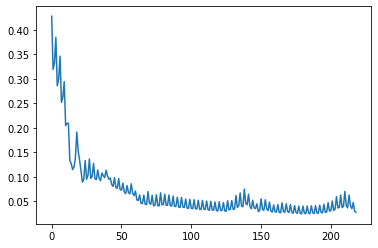

In [ ]:
plt.plot(np.arange(0,len(mae),1),mae)

In [ ]:
X_train_pred = model.predict(X_train, verbose=0)
X_train_pred = X_train_pred.flatten()
X_train = X_train.flatten()
mae_loss = np.array([np.abs(X_train_pred[i] - X_train[i]) for i in range(X_train_pred.shape[0])])
threshold = np.mean(mae_loss)
X_train = create_sequences2(df[['value']].iloc[:train_length],TIME_STEPS)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))

In [ ]:
threshold += np.std(mae_loss)
# threshold = np.max(mae_loss)

In [ ]:
X_train_pred.shape

(2820,)

In [ ]:
mae_loss.shape

(2820,)

In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
X_test_pred = X_test_pred.flatten()
change_points = np.where(np.abs(X_test_pred - X_test.flatten()) > threshold)[0]
change_points = np.add(change_points,(train_length))
indexes = np.where(change_points < len(df))
change_points = change_points[indexes]

In [ ]:
len(df) - 1432

2812

In [ ]:
X_train.shape

(94, 30, 1)

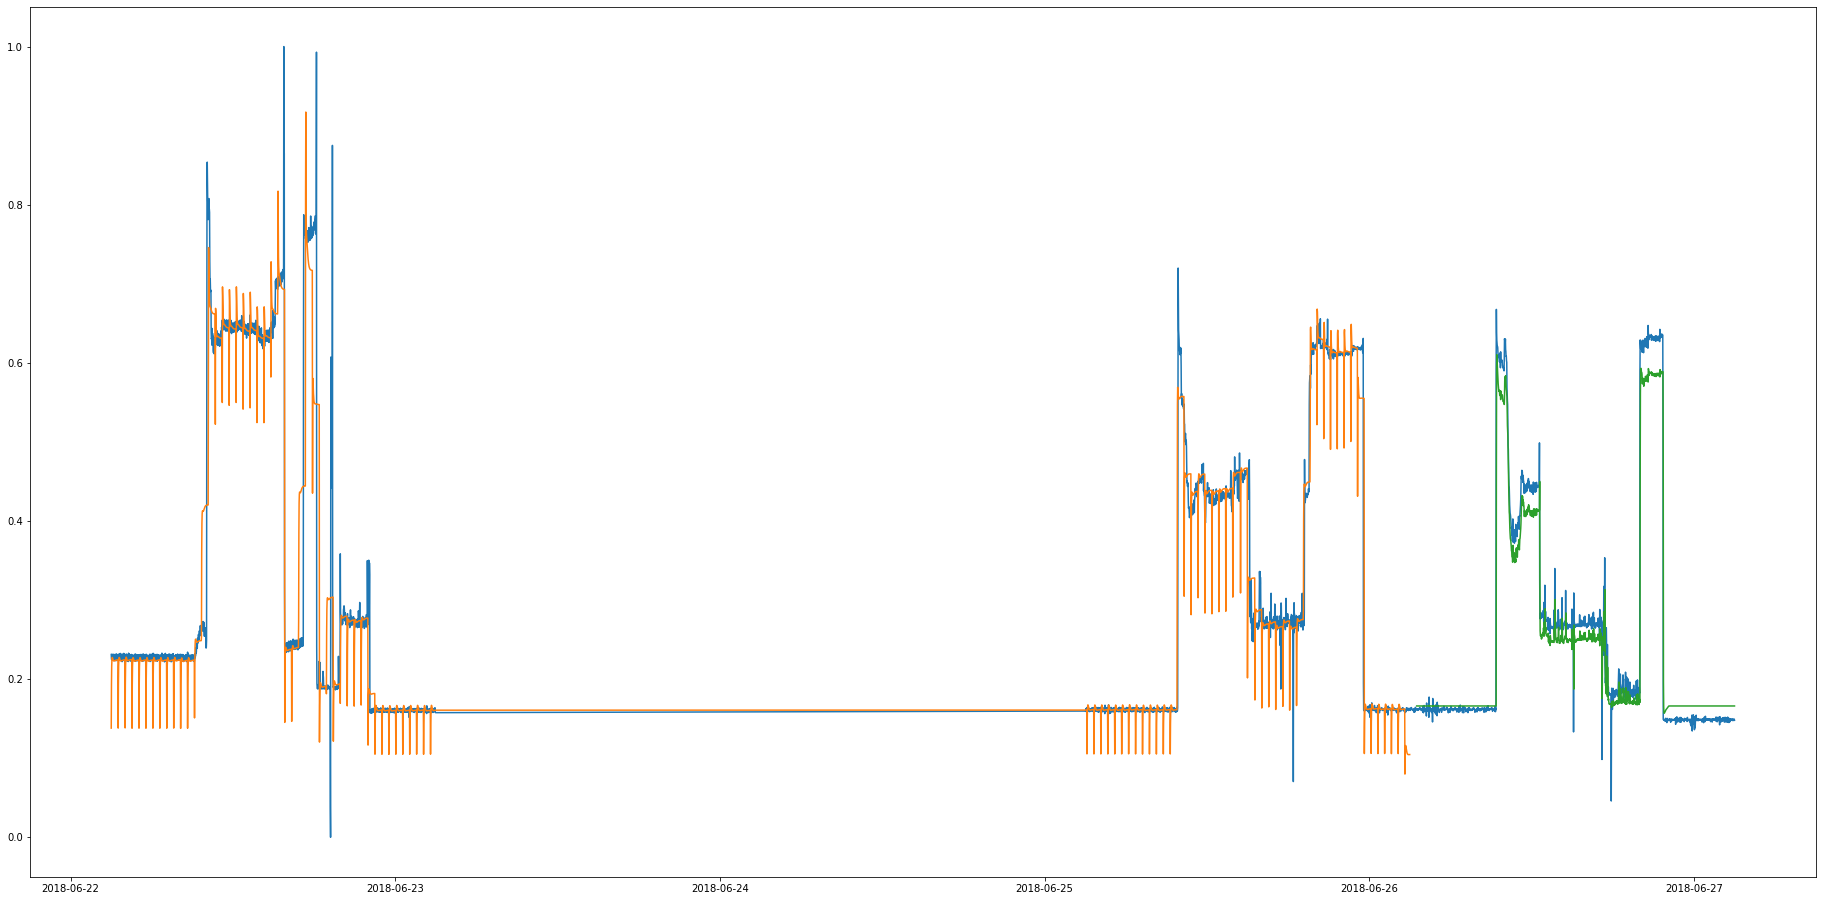

In [ ]:
plt.figure(figsize=(32,16))
plt.plot(df['timestamp'],df['value'])
diff = len(X_train_pred) - train_length
plt.plot(df['timestamp'].iloc[:(train_length)],X_train_pred[:-diff])
plt.plot(df['timestamp'].iloc[train_length+30:],y_test_pred)

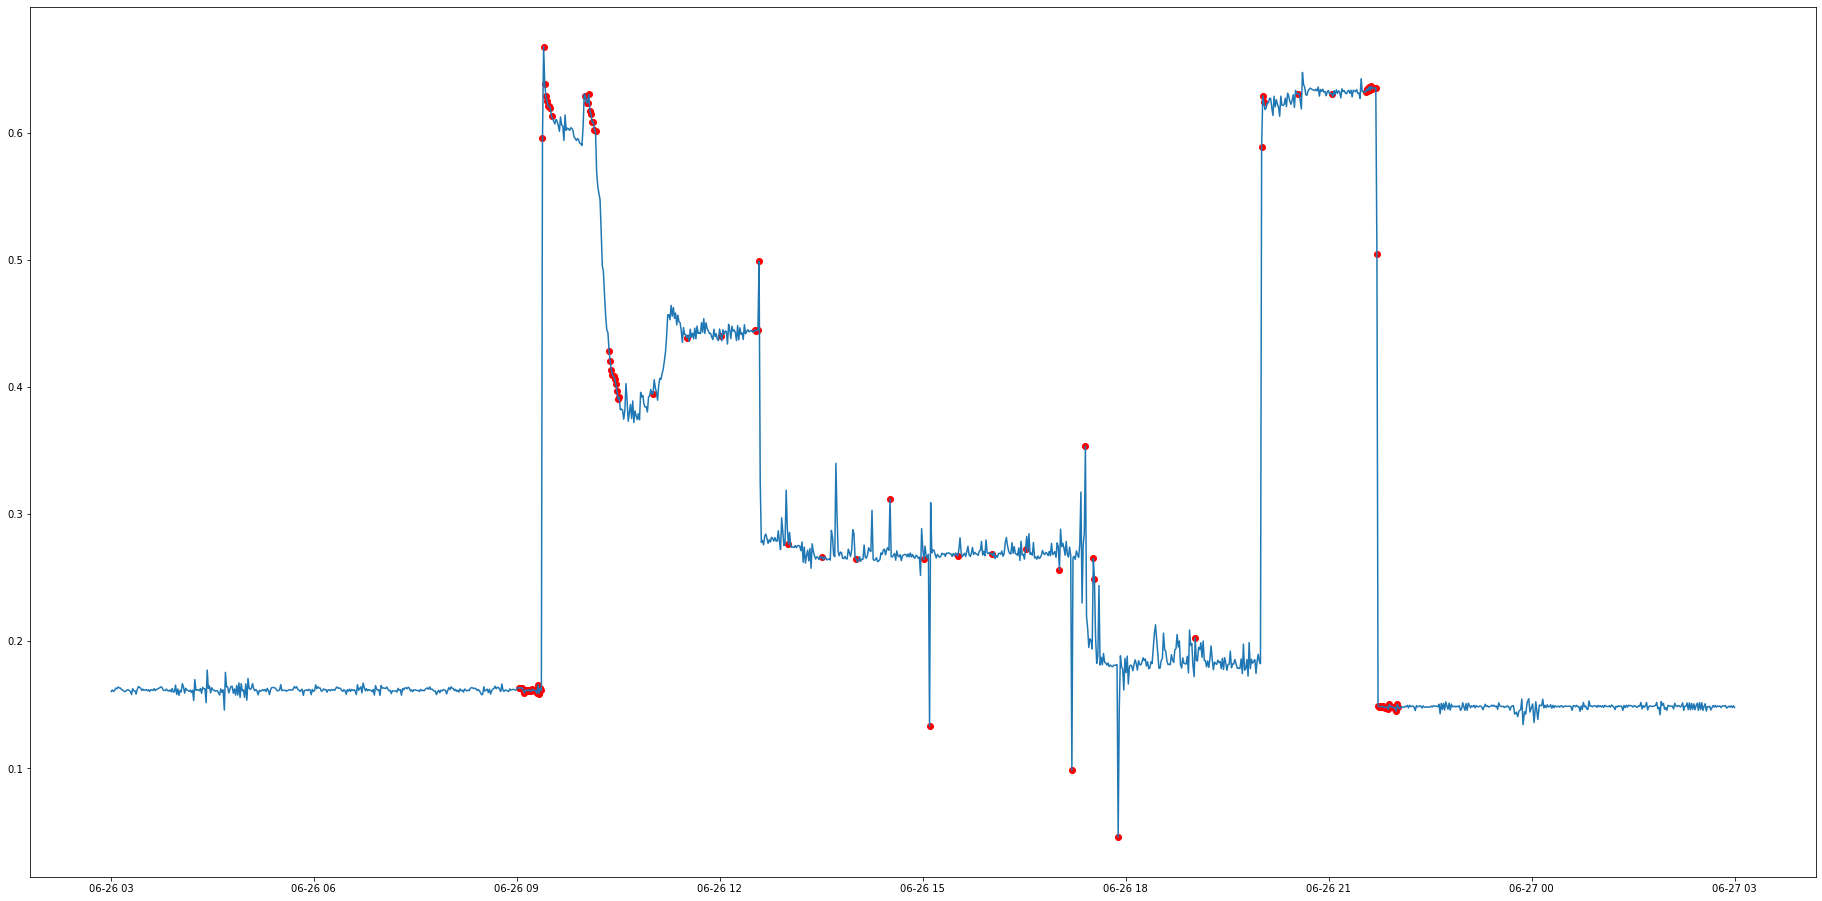

In [ ]:
plt.figure(figsize=(32,16))
plt.plot(df['timestamp'].iloc[train_length:],df['value'].iloc[train_length:])
plt.scatter(df['timestamp'].iloc[change_points],df['value'].iloc[change_points],color='r')
#plt.plot(df['timestamp'].iloc[train_length:],X_test_pred[:-8])

In [ ]:
def filter_cp(CP):
  real_cp = []
  for i in range(len(CP)):
    if (i == 0):
      real_cp.append(CP[i])
    if (i == len(CP) - 1):
      real_cp.append(CP[i])
    elif ( (CP[i]-CP[i-1]) > 28 or (CP[i+1] - CP[i]) > 28):
      real_cp.append(CP[i])   
  return np.add(np.array(real_cp),-train_length) 

In [ ]:
result = filter_cp(change_points)
result

array([ 361,  390,  420,  450,  480,  510,  540,  570,  600,  630,  660,
        690,  720,  750,  780,  810,  840,  892,  960, 1018, 1020, 1050,
       1080, 1110, 1139])

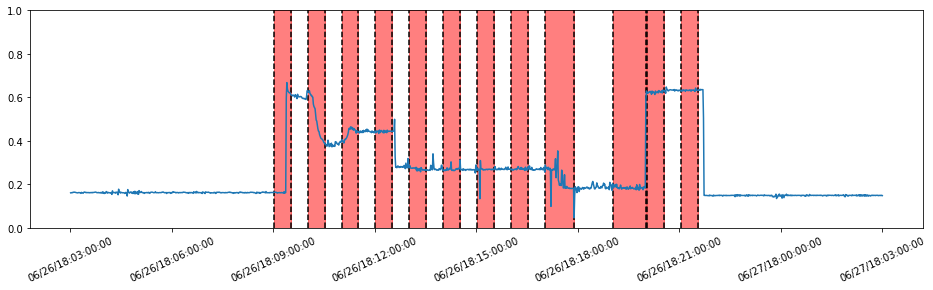

In [ ]:
plotCP(df.iloc[train_length:],result)

In [ ]:
def get_model2(Input_shape,rpt_vec=0):
  model = Sequential()
  model.add(LSTM(100, activation='relu', input_shape=Input_shape,return_sequences=False))
  model.add(RepeatVector(rpt_vec))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  model.add(keras.layers.Flatten())
  model.add(Dense(1))
  model.compile(optimizer='adam', loss="mean_squared_error",
          metrics=["mean_absolute_error"])
  return model
input_shape = (30,1)
model = get_model2(input_shape,30)

In [ ]:
X_train, y_train = create_sequences(df[['value']].iloc[:train_length],df['value'].iloc[:train_length],TIME_STEPS)
X_test, y_test  = create_sequences(df[['value']].iloc[train_length:],df['value'].iloc[:train_length],TIME_STEPS)

In [ ]:
X_train.shape[0]/32

86.9375

In [ ]:
mae = []
early_stop = keras.callbacks.EarlyStopping(monitor="loss", patience=10, mode='min')
model.fit(X_train,y_train,epochs=100, verbose=0,callbacks=[LossAndErrorPrintingCallback(),early_stop],shuffle=False)

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 30, 100)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 30, 100)           80400     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 1)             101       
_________________________________________________________________
flatten_7 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 31        
Total params: 121,332
Trainable params: 121,332
Non-trainable params: 0
_______________________________________________

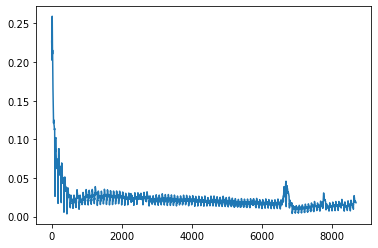

In [ ]:
plt.plot(np.arange(0,len(mae),1),mae)

In [ ]:
y_train_pred = model.predict(X_train, verbose=0)
#y_train_pred = X_train_pred.flatten()
#X_train = X_train.flatten()
mae_loss = np.array([np.abs(y_train_pred[i] - y_train[i]) for i in range(y_train_pred.shape[0])])
# X_train = create_sequences2(df[['value']].iloc[:train_length],TIME_STEPS)
# X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))

In [ ]:
mae_loss.shape

(2782, 1)

(array([1.596e+03, 6.250e+02, 3.460e+02, 1.550e+02, 2.600e+01, 6.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.5944242e-06, 1.3018136e-02, 2.6034677e-02, 3.9051220e-02,
        5.2067760e-02, 6.5084301e-02, 7.8100845e-02, 9.1117382e-02,
        1.0413393e-01, 1.1715046e-01, 1.3016701e-01, 1.4318354e-01,
        1.5620010e-01, 1.6921663e-01, 1.8223317e-01, 1.9524971e-01,
        2.0826626e-01, 2.2128280e-01, 2.3429933e-01, 2.4731588e-01,
        2.6033241e-01, 2.7334896e-01

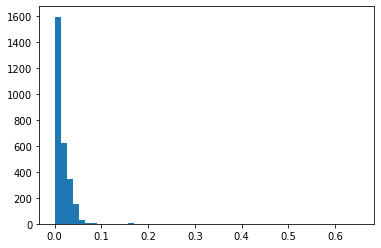

In [ ]:
plt.hist(mae_loss,bins=50)

In [ ]:
threshold = np.max(mae_loss)
threshold

0.65082866

(array([391.,  80.,   7., 333.,  20.,  14.,  20.,   9.,   2.,   2.,   2.,
         10.,  38.,  49.,  16.,  27.,  16.,   6.,   7.,  63.,  54.,  10.,
         56.,  58.,  10.,   2.,  15.,  22.,   4.,   4.,  13.,  14.,   3.,
          1.,   4.,   6.,   6.,   5.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([8.5368752e-05, 1.6516976e-02, 3.2948583e-02, 4.9380191e-02,
        6.5811798e-02, 8.2243405e-02, 9.8675013e-02, 1.1510663e-01,
        1.3153823e-01, 1.4796984e-01, 1.6440144e-01, 1.8083306e-01,
        1.9726466e-01, 2.1369627e-01, 2.3012789e-01, 2.4655949e-01,
        2.6299110e-01, 2.7942270e-01, 2.9585430e-01, 3.1228593e-01,
        3.2871753e-01, 3.4514913e-01, 3.6158073e-01, 3.7801236e-01,
        3.9444396e-01, 4.1087556e-01, 4.2730719e-01, 4.4373879e-01,
        4.6017039e-01, 4.7660199e-01, 4.9303362e-01, 5.0946522e-01,
        5.2589685e-01, 5.4232842e-01, 5.5876005e-01, 5.7519162e-01,
        5.9162325e-01, 6.0805488e-01, 6.244864

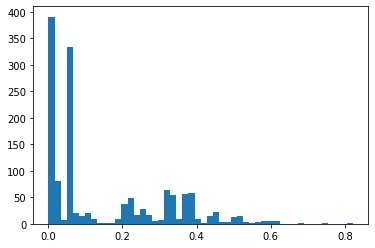

In [ ]:
y_test_pred = model.predict(X_test, verbose=0)
mae_loss = np.array([np.abs(y_test_pred[i] - y_test[i]) for i in range(y_test_pred.shape[0])])
plt.hist(mae_loss,bins=50)
#change_points = np.where(np.abs(X_test_pred - X_test.flatten()) > threshold)[0]

In [ ]:
change_points = np.where(np.abs(y_test_pred - y_test.flatten()) > threshold)[0]
change_points = np.add(change_points,(30+train_length))
indexes = np.where(change_points < len(df))
change_points = change_points[indexes]

In [ ]:
y_train_pred = y_train_pred.flatten()
y_train_pred.shape

(2782,)

In [ ]:
y_train.shape

(2782,)

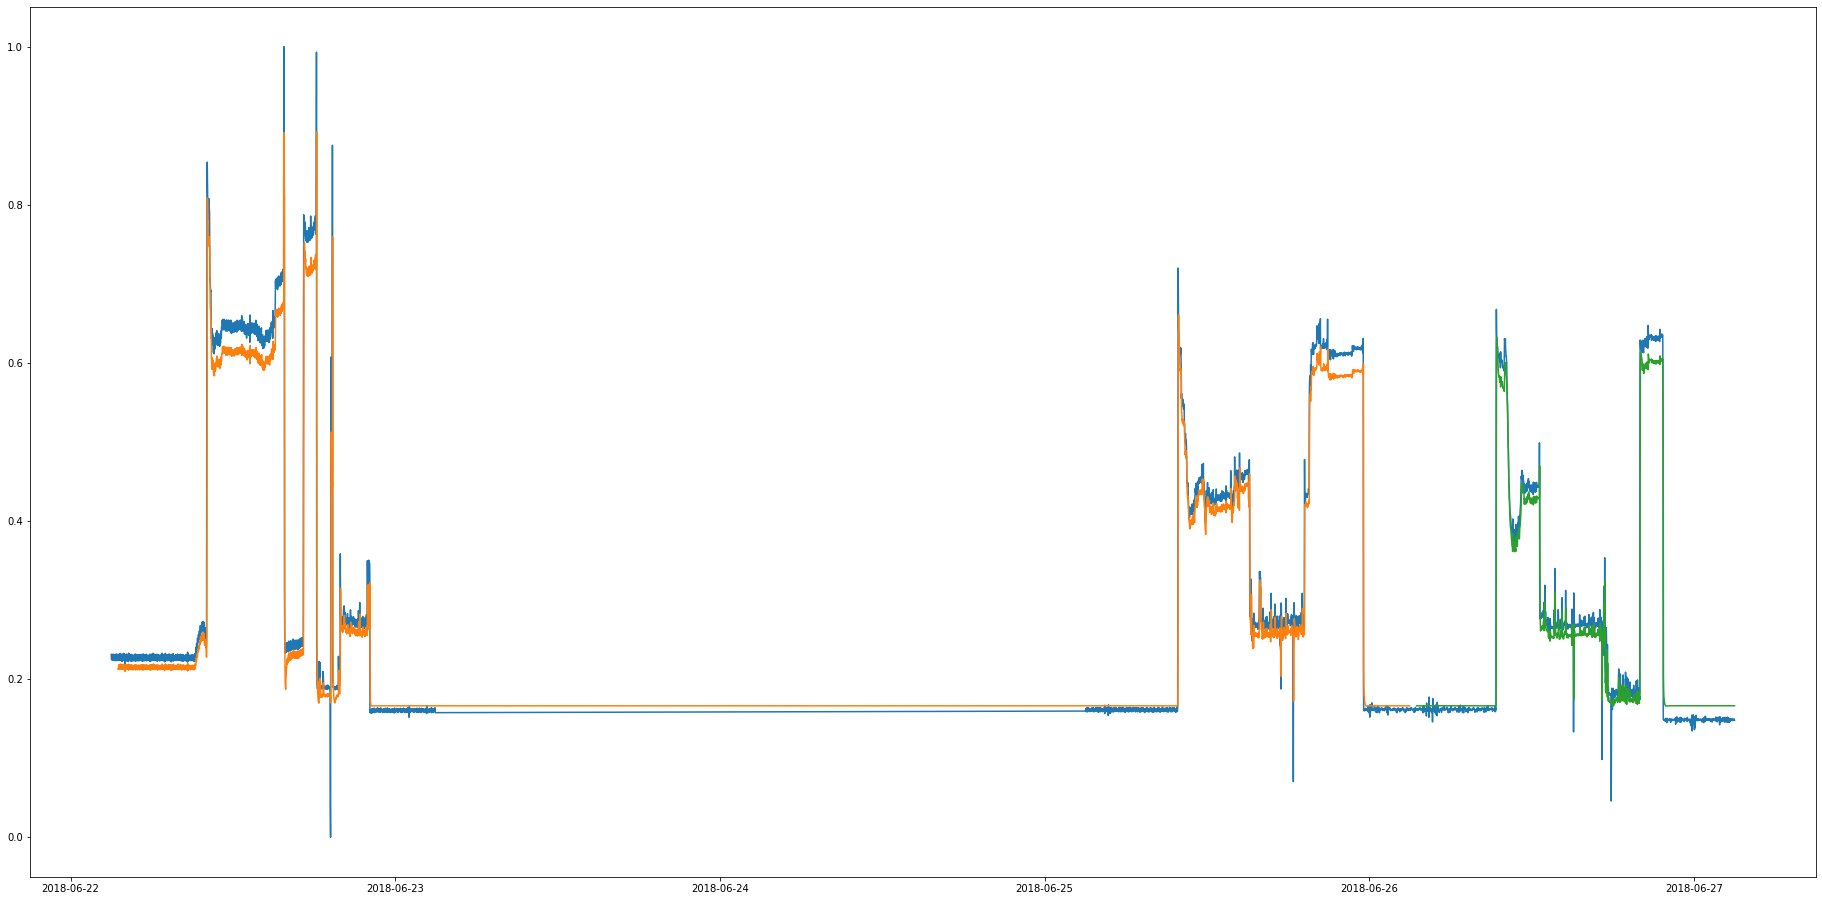

In [ ]:
plt.figure(figsize=(32,16))
plt.plot(df['timestamp'],df['value'])
diff = len(y_train_pred) - train_length
plt.plot(df['timestamp'].iloc[30:(train_length)],y_train_pred)
plt.plot(df['timestamp'].iloc[(train_length + 30): ],y_test_pred)

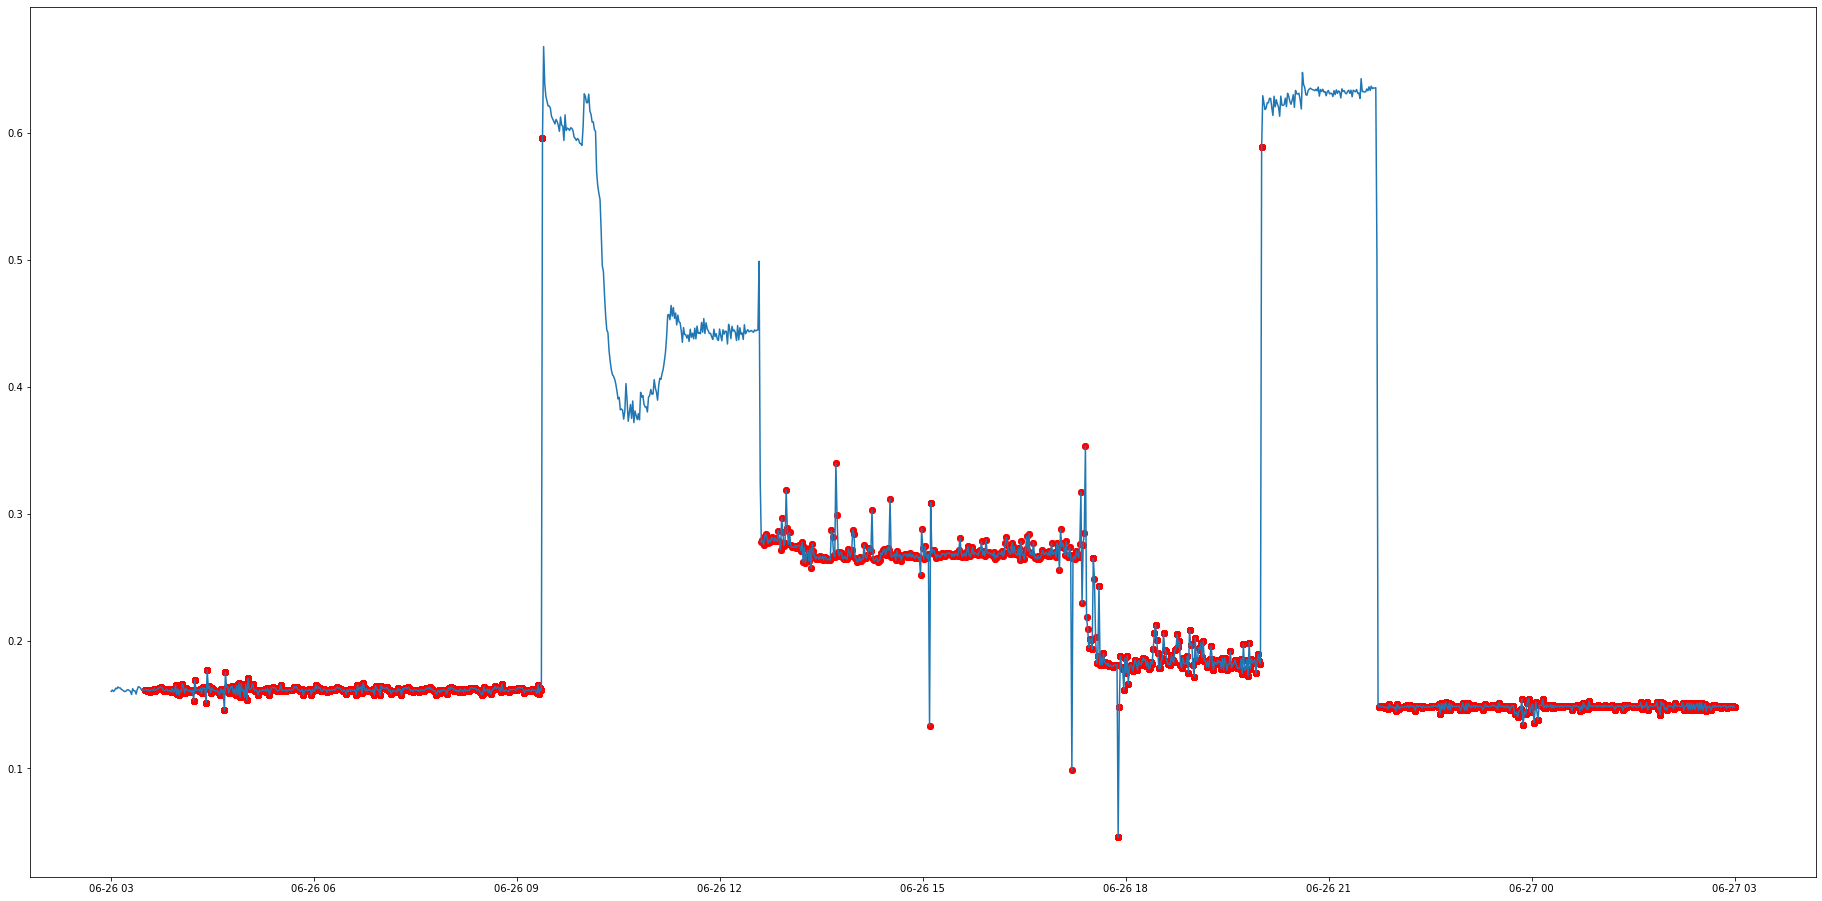

In [ ]:
plt.figure(figsize=(32,16))
plt.plot(df['timestamp'].iloc[train_length:],df['value'].iloc[train_length:])
plt.scatter(df['timestamp'].iloc[change_points],df['value'].iloc[change_points],color='r')

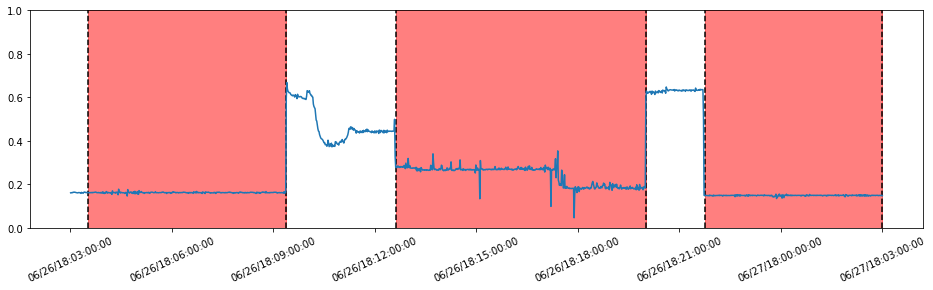

In [ ]:
result = filter_cp(change_points)
plotCP(df.iloc[train_length:],result)